Mounted at /content/drive
Loading data... (This might take 30s)
✅ Ready to train on 383560 complaints.
Splitting data into Train/Test sets...
Training Samples: 306848
Testing Samples:  76712

Step 1/2: Vectorizing Text (TF-IDF)...
✅ Text converted to numerical vectors.

Step 2/2: Training Model (Logistic Regression)...
✅ Model trained successfully!

--- MODEL PERFORMANCE ---
              precision    recall  f1-score   support

        High       0.91      0.84      0.88     30555
         Low       0.66      0.96      0.78     12919
      Medium       0.88      0.79      0.84     33238

    accuracy                           0.84     76712
   macro avg       0.82      0.86      0.83     76712
weighted avg       0.86      0.84      0.84     76712



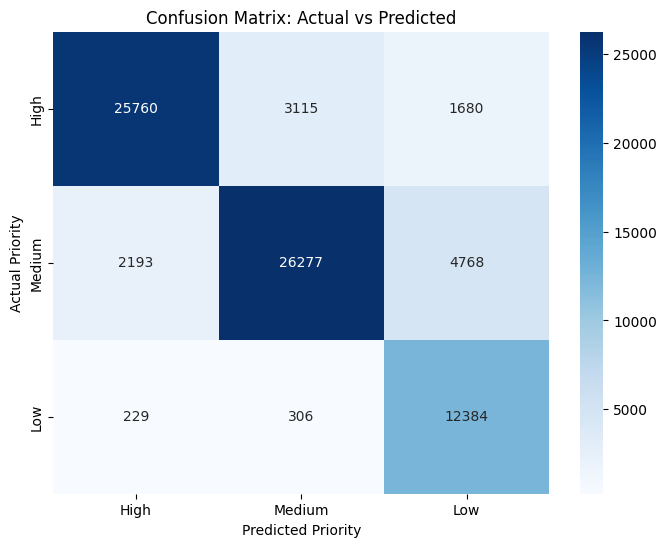


Saving model artifacts...
🚀 Saved model and vectorizer to /content/drive/My Drive/Smart Complaint Prioritizer/models


In [1]:
# --- 1. SETUP ---
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
PROJECT_PATH = "/content/drive/My Drive/Smart Complaint Prioritizer"
INPUT_FILE = f"{PROJECT_PATH}/data/processed/complaints_with_features.csv"
MODEL_DIR = f"{PROJECT_PATH}/models"

# Create models folder if missing
import os
os.makedirs(MODEL_DIR, exist_ok=True)

# --- 2. LOAD DATA ---
print("Loading data... (This might take 30s)")
df = pd.read_csv(INPUT_FILE)

# Drop any rows that might have slipped through as NaN
df = df.dropna(subset=['cleaned_narrative', 'priority'])
print(f"✅ Ready to train on {len(df)} complaints.")

# --- 3. SPLIT DATA ---
# We use 80% for training, 20% for testing
X = df['cleaned_narrative']
y = df['priority']

print("Splitting data into Train/Test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Samples: {len(X_train)}")
print(f"Testing Samples:  {len(X_test)}")

# --- 4. VECTORIZATION (TF-IDF) ---
# Convert text to numbers. We limit to top 5000 words to keep it fast on Colab.
print("\nStep 1/2: Vectorizing Text (TF-IDF)...")
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))

# Learn vocab from train data only (prevent leakage)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

print("✅ Text converted to numerical vectors.")

# --- 5. MODEL TRAINING ---
# We use Logistic Regression with 'class_weight="balanced"' to handle the imbalance we saw in EDA.
print("\nStep 2/2: Training Model (Logistic Regression)...")
model = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1)

model.fit(X_train_vec, y_train)
print("✅ Model trained successfully!")

# --- 6. EVALUATION ---
print("\n--- MODEL PERFORMANCE ---")
y_pred = model.predict(X_test_vec)

# Print the scores
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred, labels=['High', 'Medium', 'Low'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['High', 'Medium', 'Low'], yticklabels=['High', 'Medium', 'Low'])
plt.title('Confusion Matrix: Actual vs Predicted')
plt.ylabel('Actual Priority')
plt.xlabel('Predicted Priority')
plt.show()

# --- 7. SAVE THE MODEL ---
print("\nSaving model artifacts...")
joblib.dump(model, f"{MODEL_DIR}/priority_model.pkl")
joblib.dump(tfidf, f"{MODEL_DIR}/tfidf_vectorizer.pkl")
print(f"🚀 Saved model and vectorizer to {MODEL_DIR}")